In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import dense_diff_pool
from torch import Tensor
from typing import Tuple

from torch_geometric.utils import to_networkx, negative_sampling
import networkx as nx

In [4]:
import utils.torchUtils as gnn
from utils.torchUtils.cpp_geometric import layers

In [5]:
dout='simple_pair'

In [6]:
gnn.config.set_gpu(0)

In [7]:
from torch_scatter import scatter_max, scatter_min
from torch_geometric.data import Batch
from torch.utils.data import Sampler


In [8]:
from utils.torchUtils.gnn import sample_pair
from utils.torchUtils import BaseTransform

In [9]:
class GroupQuadH(BaseTransform):
    quadH = eightb.get_quadH_pairings()
    def transform(self, data : Data)->Data:
        dijets = torch.where(data.edge_index[0] < data.edge_index[1])[0]
        quadH_index = dijets[self.quadH]
        quadH_y = data.edge_y[quadH_index].sum(dim=-1)
        quadH_mask = torch.zeros((105,data.num_edges))
        for mask,index in zip(quadH_mask, quadH_index):
            mask[index] = 1
        quadH_mask = quadH_mask == 1

        # data.quadH_index = data.edge_index[:,quadH_index]
        data.quadH_mask = quadH_mask.T
        data.quadH_y = quadH_y
        return data

class SampleQuadH(BaseTransform):
    def transform(self, data : Data)->Data:
        n_quadH = data.quadH_y
        n_quadH_idx = [ torch.where(n_quadH==n)[0] for n in range(5) ]
        quadH_idx = torch.cat([ quadH_idx[torch.randperm(quadH_idx.shape[0])[:1]] for quadH_idx in n_quadH_idx ])

        data.sampled_quad_mask = data.quadH_mask.T[quadH_idx].T
        data.sampled_quad_y = data.quadH_y[quadH_idx]
        return data

In [10]:
subset = 'top8btag_signal'

In [11]:
import utils.torchUtils as gnn 

transform = None
transform = gnn.Transform(gnn.min_edge_neighbor(), GroupQuadH())
template = gnn.Dataset('../data/template',make_template=True, transform=transform)

def load_training(fn=f'../data/{subset}/MX_1000_MY_450-training', template=None):
    transform = template.transform + SampleQuadH()
    dataset = gnn.Dataset(fn,transform=transform)[:18000]
    training, validation = gnn.train_test_split(dataset, 0.2)
    # training, validation = dataset[1800:], dataset[:1800]

    batch_size = 25
    trainloader = DataLoader(training,  batch_size=batch_size, num_workers=gnn.config.ncpu)
    validloader = DataLoader(validation, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return trainloader, validloader

def load_testing(fn=f'../data/{subset}/MX_1000_MY_450-testing', template=None):
    transform = template.transform + SampleQuadH()
    sample = gnn.Dataset(fn, transform=transform)[:1000]
    # sample = [ data for data in sample if data.edge_y.sum() > 0 ]
    batch_size = 25
    testloader = DataLoader(sample, batch_size=batch_size, num_workers=gnn.config.ncpu)
    return testloader
testloader = load_testing(template=template)
trainloader, validloader  = load_training(template=template)

In [12]:
data = next(data for data in validloader.dataset)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:>)

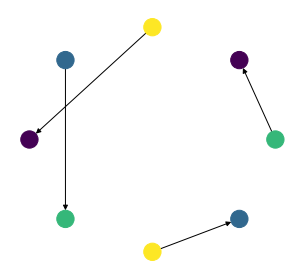

In [13]:
gnn.draw_data(data, data.quadH_mask[:,3])

In [14]:
data

Data(x=[8, 5], edge_index=[2, 64], edge_attr=[64, 5], y=[8], edge_y=[64], node_id=[8], edge_id=[64], edge_d=[64], edge_mask=[64], quadH_mask=[64, 105], quadH_y=[105], sampled_quad_mask=[64, 4], sampled_quad_y=[4])

In [15]:
for batch in validloader: break

In [42]:
# loss='mismatched_bjet_loss'
loss='std_loss'
model = gnn.modelMap['golden_quadh'](dataset=template, loss=loss,  )

In [43]:
torch.cat([ model.eval_batch(batch, quad_mask) for quad_mask in batch.sampled_quad_mask.T ])

tensor([0.5591, 0.5556, 0.5478, 0.5651, 0.5613, 0.5398, 0.5538, 0.5540, 0.5515,
        0.5517, 0.5451, 0.5513, 0.5614, 0.5634, 0.5453, 0.5549, 0.5508, 0.5727,
        0.5665, 0.5620, 0.5376, 0.5498, 0.5420, 0.5572, 0.5395, 0.5611, 0.5411,
        0.5503, 0.5674, 0.5430, 0.5620, 0.5576, 0.5494, 0.5590, 0.5431, 0.5697,
        0.5655, 0.5513, 0.5774, 0.5465, 0.5551, 0.5651, 0.5676, 0.5455, 0.5436,
        0.5477, 0.5378, 0.5360, 0.5567, 0.5468, 0.5370, 0.5602, 0.5409, 0.5496,
        0.5495, 0.5484, 0.5498, 0.5449, 0.5511, 0.5288, 0.5564, 0.5666, 0.5551,
        0.5669, 0.5607, 0.5532, 0.5619, 0.5576, 0.5446, 0.5550, 0.5451, 0.5508,
        0.5470, 0.5433, 0.5455, 0.5621, 0.5467, 0.5384, 0.5501, 0.5545, 0.5588,
        0.5578, 0.5463, 0.5497, 0.5479, 0.5569, 0.5712, 0.5519, 0.5583, 0.5522,
        0.5693, 0.5622, 0.5553, 0.5679, 0.5534, 0.5535, 0.5550, 0.5572, 0.5468,
        0.5440], grad_fn=<CatBackward>)

In [44]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=10, gpus=1*gnn.config.ngpu)
trainer.fit(model, trainloader, validloader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name        | Type          | Params
----------------------------------------------
0 | gnn_module  | GCNConvMask   | 512   
1 | gnn_norm    | BatchNorm     | 64    
2 | gnn_relu    | ReLU          | 0     
3 | pair_module | PairPredictor | 4.5 K 
4 | pair_norm   | BatchNorm     | 128   
5 | pair_relu   | ReLU          | 0     
6 | quad_module | QuadPredictor | 0     
7 | readout     | Sequential    | 27.8 K
----------------------------------------------
33.0 K    Trainable params
0         Non-trainable params
33.0 K    Total params
0.132     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 257/257 [00:27<00:00,  9.23it/s, loss=3.56, v_num=10]


In [45]:
trainer.test(model, testloader)

Testing: 100%|██████████| 40/40 [00:03<00:00, 16.77it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'auroc/test': 0.5112666487693787, 'loss/test': 3.5686275959014893}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 40/40 [00:03<00:00, 10.28it/s]


[{'loss/test': 3.5686275959014893, 'auroc/test': 0.5112666487693787}]

In [46]:
def predict_data(model, data):
    quadH_o = torch.cat([model.eval_batch(data,quad_mask) for quad_mask in data.quadH_mask.T])
    data.quadH_o = quadH_o
    return data

In [47]:
(data.quadH_y==0).sum()/105

tensor(0.5714)

In [48]:
subset = [ predict_data(model,data) for data in trainloader.dataset[:200] ] 

In [49]:
n_higgs = [ data.quadH_y[data.quadH_o.argmax()] for data in subset ]

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='PDF'>)

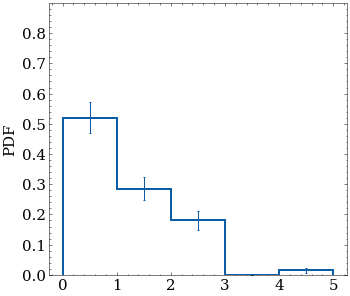

In [50]:
hist_multi([n_higgs], density=True)